In [1]:
!pip install langgraph
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 7.2 MB/s eta 0:00:00


In [2]:
from typing import List, Optional, TypedDict

In [3]:
class AgentState(TypedDict, total=False):
    user_input: str
    task_list: List[str]
    final_output: Optional[str]

In [5]:
from google.colab import userdata
groq_api_key = userdata.get('groq')

In [68]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.1-8b-instant")
llm

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x7af498f49f10>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7af498f4a3f0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [19]:
def planner_node(state: dict) -> dict:
    prompt = f"Break this task into 2-3 steps: {state['user_input']}"
    response  = llm.invoke(prompt)  # Assuming you have a function defined to call the LLM
    steps = response.content
    step_lines = [line.strip("- ").strip() for line in steps.split("\n") if line.strip()]
    print("📌 User Input:", state["user_input"])
    print("📌 User Temp Input:", steps)
    print("📌 Planner Output:", step_lines)
    return {"task_list": step_lines}

In [20]:
def executor_node(state: dict) -> dict:
    steps = state.get("task_list", [])
    final_output = " -> ".join(steps) + " -> Done!"
    return {"final_output": final_output}

In [21]:
import langgraph.graph

In [22]:
from langgraph.graph import StateGraph

In [23]:
graph = StateGraph(state_schema=AgentState)

In [24]:
graph.add_node("planner", planner_node)
graph.add_node("executor", executor_node)

graph.set_entry_point("planner")
graph.add_edge("planner", "executor")
graph.set_finish_point("executor")

In [26]:
graph_compiled = graph.compile()

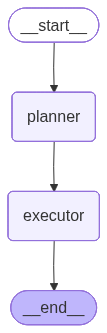

In [27]:
from IPython.display import Image, display
try:
    display(Image(graph_compiled.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [69]:
state = {"user_input": "How do Isolation Transformer work?"}
final_state = graph_compiled.invoke(state)

📌 User Input: How do Isolation Transformer work?
📌 User Temp Input: Here's a 3-step explanation of how an Isolation Transformer works:

**Step 1: Primary Coil and Secondary Coil**
An Isolation Transformer consists of two main coils - a primary coil and a secondary coil, which are separated by a layer of insulation called the 'core'. The primary coil receives the input AC power from the mains supply, while the secondary coil provides the output AC power to the connected load.

**Step 2: Mutual Induction**
When an alternating current flows through the primary coil, it generates a magnetic field. This magnetic field induces an electromotive force (EMF) in the secondary coil. Due to this induced EMF, an alternating current starts flowing through the secondary coil. This phenomenon is known as mutual induction, where the primary coil induces an EMF in the secondary coil.

**Step 3: Isolation and Output**
The secondary coil is isolated from the primary coil, meaning they are not electrically

In [70]:
print(final_state["final_output"])

Here's a 3-step explanation of how an Isolation Transformer works: -> **Step 1: Primary Coil and Secondary Coil** -> An Isolation Transformer consists of two main coils - a primary coil and a secondary coil, which are separated by a layer of insulation called the 'core'. The primary coil receives the input AC power from the mains supply, while the secondary coil provides the output AC power to the connected load. -> **Step 2: Mutual Induction** -> When an alternating current flows through the primary coil, it generates a magnetic field. This magnetic field induces an electromotive force (EMF) in the secondary coil. Due to this induced EMF, an alternating current starts flowing through the secondary coil. This phenomenon is known as mutual induction, where the primary coil induces an EMF in the secondary coil. -> **Step 3: Isolation and Output** -> The secondary coil is isolated from the primary coil, meaning they are not electrically connected. This isolation is achieved due to the phy